# setup

setup da gpu

In [1]:
!lspci | grep VGA

08:00.0 VGA compatible controller: NVIDIA Corporation TU116 [GeForce GTX 1660 Ti] (rev a1)


```
 1357  sudo apt remove "^nvidia"
 1358  sudo apt autoremove
 1359  sudo reboot
 1360  sudo apt install nvidia-driver-470
       sudo reboot
       sudo apt install nvidia-cuda-toolkit
       sudo reboot
 1392  python3 -m pip install install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html  --upgrade --force-reinstall --ignore-installed
```

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!nvidia-smi

Tue Oct 12 21:56:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0  On |                  N/A |
|  0%   46C    P8    12W / 130W |    263MiB /  5943MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- - -

In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.device_count()

1

# ambiente

In [7]:
import gym

In [8]:
env = gym.make('FrozenLake-v1')

In [9]:
env.env.render()


SFFF
FHFH
FFFH
HFFG


In [10]:
P = env.env.P # mdp

$$\text{MDP}(S,A,T,R,S_{\theta},\gamma, H)$$

* $S$ espaço de estado
* $A$ espaço de ação
* $T$ função de transição
* $R$ sinal de recompensa
* $S_{\theta}$ distribuição de estado inicial
* $\gamma$ fator de desconto
* $H$ horizonte

```
mdp = { estado : {
            acao : [ (probabilidade, proximo_estado, recompensa, estado_terminal) ]
            } 
        }
```

In [11]:
print(P)

{0: {0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 1: {0: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 2: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 3: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 2: {0: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333

# básico

até aqui (inclusive) tudo se trata de 

+ framework teórico (2)
+ equilíbrio entre recompensas de curto e longo prazo (3)
+ políticas ótimas em problemas de decisão sequencial (3)
+ equilíbrio entre exploração e uso de informação (4)

In [12]:
import numpy as np
from tqdm import tqdm

## `policy_evaluation`

_policy-evaluation equation_

$$ v_{\pi}(s) = E_{\pi} \left[ G_t \mid S_t = s \right] \xrightarrow[ ]{\text{equacao de bellman}} v_{\pi}(s) = \sum_{a}\pi (a \mid s) \sum_{s^{\prime},r} p (s^{\prime}, r \mid s, a) \left[ r + \gamma v_{\pi}(s^{\prime}) \right] $$

forma iterativa

$$ v_{k+1}(s) = \sum_{a}\pi (a \mid s) \sum_{s^{\prime},r} p (s^{\prime}, r \mid s, a) \left[ r + \gamma v_k(s^{\prime}) \right] $$

In [13]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P))
    
    while True:
        V = np.zeros(len(P))
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

## `policy_improvement`

_policy-improvement equation_

$$ \pi^{\prime}(s) = \underset{a}{argmax} \sum_{s^{\prime},r} p (s^{\prime}, r \mid s, a) \left[ r + \gamma v_k(s^{\prime}) \right]$$

In [14]:
def policy_improvement(V, P, gamma=1.0):
    Q = np.zeros( (len(P), len(P[0])), dtype=np.float64 )
    
    for s in range(len(P)):
        for a in range(len(P[s])):
            for prob, next_state, reward, done in P[s][a]:
                Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
    
    new_pi = lambda s: {s:a for s,a in enumerate( np.argmax(Q, axis=1) )}[s]
    
    return new_pi

## `policy_iteration`

In [15]:
def policy_iteration(P, gamma=1.0, theta=1e-10):
    random_actions = np.random.choice( tuple(P[0].keys()), len(P) )
    
    pi = lambda s: {s:a for s,a in enumerate( random_actions )}[s]
    
    while True:
        old_pi = {s:pi(s) for s in range(len(P))}
        V  = policy_evaluation(pi, P, gamma, theta)
        pi = policy_improvement(V, P, gamma)
        
        if old_pi == {s:pi(s) for s in range(len(P))}:
            break
    
    return V, pi

In [16]:
policy_iteration(P)

(array([0.82352941, 0.82352941, 0.82352941, 0.82352941, 0.82352941,
        0.        , 0.52941176, 0.        , 0.82352941, 0.82352941,
        0.76470588, 0.        , 0.        , 0.88235294, 0.94117647,
        0.        ]),
 <function __main__.policy_improvement.<locals>.<lambda>(s)>)

## `value_iteration`

_the value-iteration equation_

$$ v_{k+1}(s) = \underset{a}{max} \sum_{s^{\prime},r} p (s^{\prime}, r \mid s, a) \left[ r + \gamma v_k(s^{\prime}) \right]$$

In [17]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    random_actions = np.random.choice( tuple(P[0].keys()), len(P) )
    
    V = np.zeros(len(P), dtype=np.float64)
    
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        
        V = np.max(Q, axis=1)
    
    pi = lambda s: {s:a for s,a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return V, pi

In [18]:
value_iteration(P)

(array([0.82352941, 0.82352941, 0.82352941, 0.82352941, 0.82352941,
        0.        , 0.52941176, 0.        , 0.82352941, 0.82352941,
        0.76470588, 0.        , 0.        , 0.88235294, 0.94117647,
        0.        ]),
 <function __main__.value_iteration.<locals>.<lambda>(s)>)

## `pure_exploitation`

In [19]:
def pure_exploitation(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = "Pure exploitation"
    for e in tqdm(range(n_episodes), desc="Episodes for: " + name, leave=True):
        action = np.random.randint(len(Q)) # action = np.argmax(Q)
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, actions

In [20]:
pure_exploitation(env.env)

Episodes for: Pure exploitation: 100%|██████████| 5000/5000 [00:00<00:00, 103187.51it/s]


('Pure exploitation',
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([2, 0, 1, ..., 3, 3, 1], dtype=int32))

## `epsilon_greedy`

In [21]:
def epsilon_greedy(env, epsilon=0.1, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = "E-greedy {}".format(epsilon)
    for e in tqdm(range(n_episodes), desc="Episodes for: " + name, leave=True):
        # action = np.random.randint(len(Q)) # action = np.argmax(Q)
        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, actions

In [22]:
epsilon_greedy(env.env)

Episodes for: E-greedy 0.1: 100%|██████████| 5000/5000 [00:00<00:00, 97775.71it/s]


('E-greedy 0.1',
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

## `lin_dec_epsilon_greedy`

_linearly decaying epsilon-greedy strategy_

In [23]:
def lin_dec_epsilon_greedy(env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.05, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = "Lin e-greedy {} {} {}".format(init_epsilon, min_epsilon, decay_ratio)
    for e in tqdm(range(n_episodes), desc="Episodes for: " + name, leave=True):
        decay_episodes = n_episodes * decay_ratio
        
        epsilon = (1 - e)/decay_episodes
        epsilon *= init_epsilon - min_epsilon
        epsilon += min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)
        
        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, actions

In [24]:
lin_dec_epsilon_greedy(env.env)

Episodes for: Lin e-greedy 1.0 0.01 0.05: 100%|██████████| 5000/5000 [00:00<00:00, 47751.97it/s]


('Lin e-greedy 1.0 0.01 0.05',
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

## `exp_dec_epsilon_greedy`

In [25]:
def exp_dec_epsilon_greedy(env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.1, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    
    name = "Exp e-greedy {} {} {}".format(init_epsilon, min_epsilon, decay_ratio)
    for e in tqdm(range(n_episodes), desc="Episodes for: " + name, leave=True):
        if np.random.random() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, actions

In [26]:
exp_dec_epsilon_greedy(env.env)

Episodes for: Exp e-greedy 1.0 0.01 0.1: 100%|██████████| 5000/5000 [00:00<00:00, 100419.08it/s]


('Exp e-greedy 1.0 0.01 0.1',
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([2, 2, 0, ..., 3, 0, 0], dtype=int32))

## `optimistic_initialization`

In [27]:
def optimistic_initialization(env, optimistic_estimate=1.0, initial_count=100, n_episodes=5000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.float64)
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = "Optimistic {} {}".format(optimistic_estimate, initial_count)
    for e in tqdm(range(n_episodes), desc="Episodes for: " + name, leave=True):
        action = np.argmax(Q)
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, actions

In [28]:
optimistic_initialization(env.env)

Episodes for: Optimistic 1.0 100: 100%|██████████| 5000/5000 [00:00<00:00, 124375.17it/s]


('Optimistic 1.0 100',
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([[0.99009901, 1.        , 1.        , 1.        ],
        [0.99009901, 0.99009901, 1.        , 1.        ],
        [0.99009901, 0.99009901, 0.99009901, 1.        ],
        ...,
        [0.07407407, 0.07407407, 0.07412898, 0.07412898],
        [0.07407407, 0.07407407, 0.07407407, 0.07412898],
        [0.07407407, 0.07407407, 0.07407407, 0.07407407]]),
 array([0, 1, 2, ..., 1, 2, 3], dtype=int32))

- - -

o que segue são alguns detalhes periféricos:

* _softmax exploration strategy_ $$ \pi(a) = \frac{e^{\left( \frac{Q(a)}{\tau} \right)}}{\sum_{b=0}^{B} e^{\left( \frac{Q(b)}{\tau} \right)}} $$ 
* _upper confidence bound strategy_ $$ A_e = \underset{a}{argmax} \left[ Q_{e}(a) + c\sqrt{\frac{ln\,e}{N_e(a)}}\right] $$
* _thompson sampling strategy_

# $V_{\pi}(s)$ : estimando valor de políticas

+ até aqui os efeitos das ações não foram levados em conta

a ideia agora é olhar para formas de **estimar o valor das políticas sem o mdp**, o que tem a ver com a ideia de **predição** (do futuro), dado que o valor é definido como o valor esperado das recompensas descontadas

logo a ideia será **otimizar as políticas sem o mdp**, o que está associado ao **problema do controle**, em que o comportamento do agente é melhorado

ambas combinadas dão origem ao _reinforcement learning_

_(_

_no deep reinforcement learning os agentes aprendem a partir de feedbacks que são_

+ sequenciais (não one-shot)
+ evaluativos (não supervisionado)
+ amostados (não exaustivo)

_)_

# $Q_{\pi}(s,a)$ : otimizando políticas 

a partir daqui o esquema vai ser caminhar para o aprendizado por pura tentativa e erro sem o mdp!

aqui entra o q-learning e o sarsa!

# evoluindo os agentes

aqui finalmente entra no jogo os dados! os _model-based reinforcement learning_

- - -

daqui pra trás o esquema foi o chamado **tabular reinforcement learning**, seguindo o roteiro

<p style="text-align: justify;"><b>2</b> representação do problema em mdp ---> <b>3</b> algoritmos que resolvem (encontram comportamento ótimo d) esses mdps sequenciais ---> <b>4</b> algoritmos pra tomar decisão sem acesso ao mdp (dando origem ao aprendizado por tentativa e erro) ---> <b>5</b> junta a incerteza do 4 com a sequencialidade do 3 dando origem a agentes que estimam políticas ---> <b>6</b> estudo dos agentes que encontram políticas ótimas em problemas de decisão sequencial sob incerteza, dando orgiem a agentes que aprendem por tentativa e erro capazes de atingir políticas ótimas ---> <b>7</b> otimizar agentes de tentativa e erro</p>

agora o lance é 

# o aprendizado por reforço profundo

há 5 abordagens

1. _value-based_
2. _policy-based_
3. _actor-critic_
4. _model-based_
5. _gradient-free_

## nfq

_neural fitted q_

escolhas:

1. value function to approximate (--> action-value $q(s,a) :\to Q(s,a;\theta)$)
2. arquitetura (--> state-in-values-out architecture)
3. o que otimizar (--> state-in-values-out architecture)
4. target para a evaluação de política (--> temporal-difference)
5. estrategia de exploração (--> epsilon-greedy)
6. loss function (--> mse)
7. optimization method (--> rmsprop)

<br/>

ideal objetive: $L_i(\theta_i) = E_{s,a}\left[ \left( q_{*}(s,a) - Q(s,a;\theta_i)\right)^2 \right]$

em que $$ q_{*}(s,a) = \underset{\pi}{max} E_{\pi} \left[ G_t \mid S_t=s, A_t=a \right] $$

<br/>

td targets can be either on-policy (SARSA) $$ y_{i}^{\text{SARSA}} = R_{t+1} + \gamma Q (S_{t+1}, A_{t+1}; \theta_{i}) $$ or off-policy (Q-learning) $$ y_{i}^{\text{Q-LEARNING}} = R_{t+1} + \gamma  \underset{a}{max} Q (S_{t+1}, a; \theta_{i}) $$

<br/>

então substituindo $q_{*}(s,a)$ por $y_{i}^{\text{Q-LEARNING}}$:

$$L_i(\theta_i) = E_{s,a,r,s^{\prime}}\left[ \left( r + \gamma  \underset{a^{\prime}}{max} Q (s^{\prime}, a^{\prime}; \theta_{i}) - Q(s,a;\theta_i)\right)^2 \right]$$

e diferenciando

$$ \nabla_{\theta_{i}} L_i(\theta_i) = E_{s,a,r,s^{\prime}} \left[ \left( r + \gamma  \underset{a^{\prime}}{max} Q (s^{\prime}, a^{\prime}; \theta_{i}) - Q(s,a;\theta_i)\right)\nabla_{\theta}Q(s,a;\theta_i) \right]$$

observação: a derivada acima está um pouco esquisita, porque o termo _target_ também depende de $\theta$, mas a ideia[[1](https://ieor8100.github.io/rl/docs/Lecture%203%20-%20Q-learning%20function%20approximation.pdf)] é que o termo target depende unicamente do estado seguinte, portanto o termo com _argmax_ não é transformado pelo $\nabla$.

In [29]:
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt

from gym import wrappers

%matplotlib inline

In [30]:
class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        self.hidden_layers = nn.ModuleList()
        
        for i in range(len(hidden_dim)-1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.activation_fc( self.input_layer(x) )
        
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc( hidden_layer(x) )

        x = self.output_layer(x)
        
        return x

_q-learning target_

```python
q_sp = self.online_model(next_states).detach()

max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
max_a_q_sp =* (1 - is_terminals)

target_q_s = rewards + self.gamma * max_a_q_sp

q_sa = self.online_model(states).gather(1, actions)
```

_handling terminal states_

```python
new_state, reward, is_terminal, info = env.step(action)

is_truncated = "TimeLimit.trucated" in info and info["TimeLimit.trucated"]
is_failure = is_terminal and not is_truncated

experience = (state, action, reward, new_state, float(is_failure))
```

In [31]:
class EGreedyStrategy():
    """ ... """
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
        
        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))
        
        return action

reorganizando:

In [32]:
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cpu"

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=(64,64), activation_fc=F.relu):
        super(FCQ, self).__init__()
        
        self.activation_fc = activation_fc
        
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim)-1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.activation_fc( self.input_layer(x) )
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc( hidden_layer(x) )
        x = self.output_layer(x)
        
        return x

class Agent(object):
    def __init__(self, state_size, action_size, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.model = FCQ(state_size, action_size)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.001)
        self.gamma = gamma
        self.memory = list()
    
    def step(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_values = self.model(state)
        
        if random.random() > eps:  # If eps=1 --> always random choice
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
        return action
    
    def learn(self):
        states, actions, rewards, next_states, dones = list(map(list, zip(*self.memory)))
        states = torch.FloatTensor(states).to(DEVICE)
        next_states = torch.FloatTensor(next_states).to(DEVICE)
        rewards = torch.FloatTensor(rewards).to(DEVICE).view(-1, 1)
        actions = torch.LongTensor(actions).to(DEVICE).view(-1, 1)
        dones = torch.IntTensor(dones).to(DEVICE).view(-1, 1)
        
        max_a_q_sp = self.model(next_states).detach().max(1)[0].unsqueeze(1) * (1 - dones)
        target_q_s = rewards + max_a_q_sp
        q_sa = self.model(states).gather(1, actions)
        
        loss = F.mse_loss(target_q_s, q_sa)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []

- - -

In [33]:
env = gym.make("CartPole-v1")

In [34]:
state_size  = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

In [35]:
EPISODES = 20000
scores = list()

for e in range(EPISODES+1):
    EPS = max(1-e/EPISODES, 0.05)  # Exploratory Rate Decay for E-Greedy Policy
    state = env.reset()
    done = False
    score = 0
    
    while not(done):
        action = agent.act(state, EPS)
        next_state, reward, done, _ = env.step(action)
        score += reward
        agent.step(state, action, score, next_state, done)
        state = next_state
    agent.learn()  # Learn after collecting experiences by End of Episode
    scores.append(score)
    
    if e % 1000 == 0 and e>1:
        print("Episode: {}/{}, Score: Rolling Mean: {} - Mean: {} - Median: {} / EPS: {:.2f} ".format(e, EPISODES, int(np.mean(scores[-100:])), int(np.mean(scores)), int(np.median(scores)), EPS))   
    if int(np.mean(scores[-100:])) > 195:
        print("Environment CartPole-v1 is solved since average reward is greater than or equal to 195 over 100 consecutive trials")        
        break

Episode: 1000/20000, Score: Rolling Mean: 20 - Mean: 22 - Median: 19 / EPS: 0.95 
Episode: 2000/20000, Score: Rolling Mean: 20 - Mean: 21 - Median: 18 / EPS: 0.90 
Episode: 3000/20000, Score: Rolling Mean: 26 - Mean: 22 - Median: 19 / EPS: 0.85 
Episode: 4000/20000, Score: Rolling Mean: 34 - Mean: 24 - Median: 20 / EPS: 0.80 
Episode: 5000/20000, Score: Rolling Mean: 38 - Mean: 27 - Median: 22 / EPS: 0.75 
Episode: 6000/20000, Score: Rolling Mean: 47 - Mean: 29 - Median: 23 / EPS: 0.70 
Episode: 7000/20000, Score: Rolling Mean: 54 - Mean: 32 - Median: 25 / EPS: 0.65 
Episode: 8000/20000, Score: Rolling Mean: 62 - Mean: 35 - Median: 27 / EPS: 0.60 
Episode: 9000/20000, Score: Rolling Mean: 97 - Mean: 40 - Median: 29 / EPS: 0.55 
Episode: 10000/20000, Score: Rolling Mean: 130 - Mean: 48 - Median: 32 / EPS: 0.50 
Episode: 11000/20000, Score: Rolling Mean: 189 - Mean: 58 - Median: 36 / EPS: 0.45 
Environment CartPole-v1 is solved since average reward is greater than or equal to 195 over 10

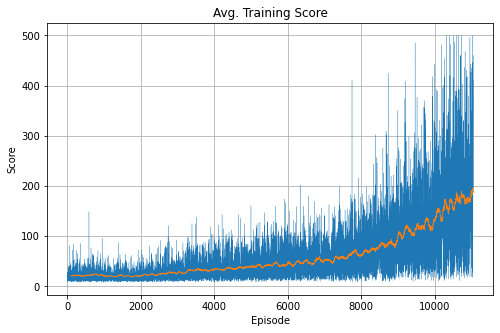

In [36]:
pd.Series(scores).plot(linewidth=0.25)
pd.Series(scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Avg. Training Score")
plt.grid()

In [37]:
import gym
from gym import wrappers

env = wrappers.Monitor(env, "./random", force=True)
env.reset()
state = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

In [38]:
import gym
from gym import wrappers

env = wrappers.Monitor(env, "./agente", force=True)
env.reset()
state = env.reset()
for _ in range(100):
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

- - -

# buscando a generalização (do dql)

![](../img/nfq_2.png)

* _[deque](https://docs.python.org/3/library/collections.html#collections.deque)_ : listas eficientes pra append e pop

```python
class Model():
    def __init__(dim_estados, dim_acoes, hparam_rede_):
        ... # define variaveis locais
        modelo = constroi_modelo()
    
        
    def constroi_modelo():
        ... # cria objeto do modelo em funcao de variaveis locais
        return modelo
    
    
    def forward(estado):
        ... # propaga variaveis de estado atraves do modelo
        return output
    

class Agent():
    def __init__():
        # vars_ambiente
        dim_estados = ...
        dim_acoes = ...
        # vars_agente
        memoria = deque()
        hparam_exploracao_1 = ...
        hparam_exploracao_N = ...
        # vars_modelo
        hparam_rede_1 = ...
        hparam_rede_N = ...
        # vars_otimizacao
        opt_funcao_perda = ...
        opt_otimizador = ...
        
        modelo = Model(dim_estados, dim_acoes, hparam_rede_)
     
        
    def act(estado):
        acao = modelo.predict(estado)
        ... # aplica ou nao exploration-exploitation em funcao de hparam_exploracao_
        return acao

    
    def remember(estado, acao, reward, proximo estado, done):
        ... # manda estado, acao, reward, proximo estado, done para memoria
    
        
    def learn(estado, acao, reward, proximo estado, done):
        ... # traz estados, acoes, rewards, proximos estados, dones da memoria
        ... # calcula target e predicao em funcao de proximos estados
        loss = opt_funcao_perda( predicao, target )
        loss.opt_otimizador()
        loss.backward()
        opt_otimizador.step()
        ... # limpa memoria

        
class Solver():
    def __init__(ambiente):
        env = ambiente
        agent = Agent(vars_ambiente, vars_agente, vars_modelo)
        scores = list()
        
    
    for episode in NUM_EPISODES:
        state = env.reset()
        score = 0
        done = False
        ... # distribuicao de estrategia de exploration-exploitation
        while not(done):
            acao = agent.act(state, args**)                # observe state -> take action
            next_state, reward, done, _ = env.step(action) # feedback -> new state
            score += reward                                # recompensa
            agent.step(state, next_state, reward, done)
            state = next_state                             # novo estado
        agent.learn()
        scores.append(score)
        
        ... # log das épocas
        ... # critério de resolução
```

algumas referências

* [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/)
* [Neural Network Architecture: Criteria for Choosing the Number and Size of Hidden Layers | Baeldung on Computer Science](https://www.baeldung.com/cs/neural-networks-hidden-layers-criteria)
* [An Introduction to Reinforcement Learning Q-Learning with Decision Trees | by Chakrit Yau | Towards Data Science](https://towardsdatascience.com/reinforcement-learning-q-learning-with-decision-trees-ecb1215d9131)

# testando a generalização

In [278]:
import collections
import random
import torch
import torch.optim         as optim
import torch.nn            as nn
import torch.nn.functional as F

import gym
from gym import wrappers

import torchinfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc

In [2]:
DEVICE = "cpu"

In [3]:
class Model(nn.Module):
    def __init__(self, dim_estados, dim_acoes, hparam_rede):
        super(Model, self).__init__()
        
        self.hparam_rede = dict()
        
        self.dim_estados = dim_estados
        self.dim_acoes = dim_acoes
        self.hparam_rede = hparam_rede
        
        self.constroi_modelo()
    
        
    def constroi_modelo(self):
        self.input = nn.Linear( self.dim_estados, self.hparam_rede['hidden_layers'][0] )
        self.hidden = nn.ModuleList()
        for i in range(len(self.hparam_rede['hidden_layers'])-1):
            self.hidden.append( nn.Linear(self.hparam_rede['hidden_layers'][i], self.hparam_rede['hidden_layers'][i+1]) )
        self.output = nn.Linear( self.hparam_rede['hidden_layers'][-1], self.dim_acoes )
    
    
    def forward(self, estado):
        x = estado
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.hparam_rede['func_ativacao']( self.input(x) )
        for h in self.hidden:
            x = self.hparam_rede['func_ativacao']( h(x) )
        x = self.output(x)
        
        return x

In [4]:
class Agent(object):
    def __init__(self, hparams_ambiente, hparams_model, hparams_reforco):
        self.dim_estados = hparams_ambiente['estados']
        self.dim_acoes = hparams_ambiente['acoes']

        self.hparams_model = dict()
        self.hparams_reforco = dict()
        self.memoria = collections.deque()

        self.hparams_model['hidden_layers'] = hparams_model['hidden_layers']
        self.hparams_model['func_ativacao'] = hparams_model['func_ativacao']
        self.modelo = Model(self.dim_estados, self.dim_acoes, self.hparams_model)
        self.hparams_model['func_opt'] = hparams_model['func_opt'](self.modelo.parameters(), lr=0.001)
        self.hparams_model['func_loss'] = hparams_model['func_loss']
     
        self.hparams_reforco['gamma'] = 0.99
        
        
    def act(self, estado, epsilon=0.0):
        x = torch.from_numpy(estado).float().unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            acoes = self.modelo(x)
        
        if random.random() > epsilon:
            return np.argmax(acoes.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.dim_acoes))

    
    def remember(self, estado, acao, reward, proximo_estado, done):
        self.memoria.append( (estado, acao, reward, proximo_estado, done) )
    
        
    def learn(self):
        estados, acoes, rewards, prx_estados, dones = list(map(list, zip(*self.memoria)))

        estados = torch.FloatTensor(estados).to(DEVICE)
        prx_estados = torch.FloatTensor(prx_estados).to(DEVICE)
        acoes = torch.LongTensor(acoes).to(DEVICE).view(-1, 1)
        rewards = torch.FloatTensor(rewards).to(DEVICE).view(-1, 1)
        dones = torch.IntTensor(dones).to(DEVICE).view(-1, 1)
        
        max_a_q_sp = self.modelo(prx_estados).detach().max(1)[0].unsqueeze(1) * (1 - dones)
        target_q_s = rewards + max_a_q_sp
        q_sa = self.modelo(estados).gather(1, acoes)
        
        loss = self.hparams_model['func_loss']( target_q_s, q_sa )
        self.hparams_model['func_opt'].zero_grad()
        loss.backward()
        self.hparams_model['func_opt'].step()
        self.memoria = collections.deque()

In [5]:
class Solver():
    def __init__(self, ambiente, hparams_model, hparams_reforco):
        self.env = ambiente
        
        self.hparams_ambiente = dict()
        self.hparams_model = hparams_model
        self.hparams_reforco = hparams_reforco
        
        self.hparams_ambiente['estados'] = self.env.observation_space.shape[0]
        self.hparams_ambiente['acoes'] = self.env.action_space.n
        
        self.agent = Agent(self.hparams_ambiente, self.hparams_model, self.hparams_reforco)
        self.scores = list()
        
    def solve(self, episodios):
        estado = self.env.reset()
        
        for e in range(episodios + 1):
            estado = self.env.reset()
            score = 0
            done = False
            epsilon = max( 1 -  e/episodios, 0.05)

            while not(done):
                acao = self.agent.act(estado, epsilon)                     # observe state -> take action
                prx_estado, reward, done, _ = self.env.step(acao)          # feedback -> new state
                score += reward                                            # recompensa
                self.agent.remember(estado, acao, score, prx_estado, done)
                estado = prx_estado                                        # novo estado
            self.agent.learn()
            self.scores.append(score)

            if (e % 1000 == 0) and (e > 1):
                print( "episodio : {:>6} de {:>6}  |  (media movel, media, mediana, epsilon) = ({:>3}, {:>3}, {:>3}, {:>3})".format(
                    e, episodios, int(np.mean(self.scores[-100:])), int(np.mean(self.scores)), int(np.median(self.scores)), epsilon) )
            
            if int(np.mean(self.scores[-100:])) > 195:
                print("RESOLVIDO!")
                break

In [98]:
env = gym.make("CartPole-v1")

hparams_model = {
    "hidden_layers" : (64, 64) , 
    "func_ativacao" : F.relu ,
    "func_opt" : optim.RMSprop , 
    "func_loss" : F.mse_loss , 
}

hparams_reforco = {    
}

RL = Solver(gym.make("CartPole-v1"), hparams_model, hparams_reforco)

In [7]:
RL.solve(20000)

episodio :   1000 de  20000  |  (media movel, media, mediana, epsilon) = ( 21,  22,  19, 0.95)
episodio :   2000 de  20000  |  (media movel, media, mediana, epsilon) = ( 26,  22,  19, 0.9)
episodio :   3000 de  20000  |  (media movel, media, mediana, epsilon) = ( 28,  24,  20, 0.85)
episodio :   4000 de  20000  |  (media movel, media, mediana, epsilon) = ( 35,  26,  22, 0.8)
episodio :   5000 de  20000  |  (media movel, media, mediana, epsilon) = ( 37,  28,  23, 0.75)
episodio :   6000 de  20000  |  (media movel, media, mediana, epsilon) = ( 49,  30,  24, 0.7)
episodio :   7000 de  20000  |  (media movel, media, mediana, epsilon) = ( 58,  34,  26, 0.65)
episodio :   8000 de  20000  |  (media movel, media, mediana, epsilon) = ( 83,  38,  28, 0.6)
episodio :   9000 de  20000  |  (media movel, media, mediana, epsilon) = (109,  44,  31, 0.55)
episodio :  10000 de  20000  |  (media movel, media, mediana, epsilon) = (130,  53,  34, 0.5)
RESOLVIDO!


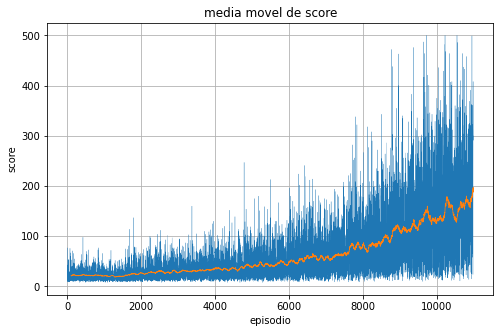

In [8]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

In [102]:
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(250):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

In [103]:
def env_savegif(frames, path, fname):
    try:
        plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    except:
        plt.figure(figsize=(frames[0].get_size()[1] / 72.0, frames[0].get_size()[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save(path + fname, writer='imagemagick', fps=60)

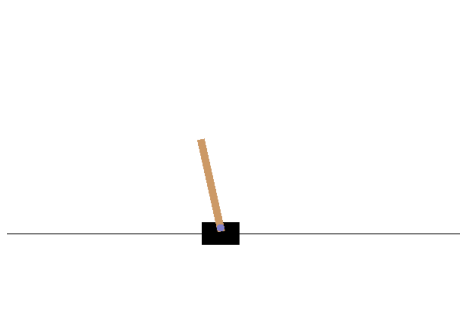

In [104]:
env_savegif(frames, "./", "random.gif")

generalizacao de framework

In [107]:
env = gym.make("MountainCar-v0")
MountainCarMountainCar

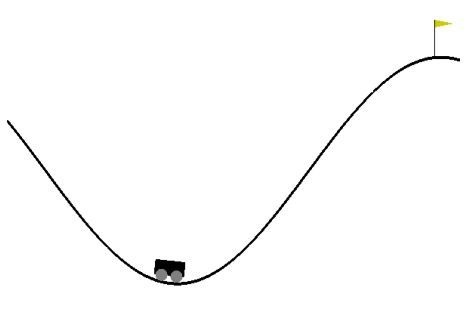

In [108]:
env_savegif(frames, "./", "random.gif")

treinando

In [109]:
hparams_model = {
    "hidden_layers" : (64, 64) , 
    "func_ativacao" : F.relu ,
    "func_opt" : optim.RMSprop , 
    "func_loss" : F.mse_loss , 
}

hparams_reforco = {    
}

RL = Solver(gym.make("MountainCar-v0"), hparams_model, hparams_reforco)

In [110]:
RL.solve(20000)

episodio :   1000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.95)
episodio :   2000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.9)
episodio :   3000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.85)
episodio :   4000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.8)
episodio :   5000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.75)
episodio :   6000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.7)
episodio :   7000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.65)
episodio :   8000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.6)
episodio :   9000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.55)
episodio :  10000 de  20000  |  (media movel, media, mediana, epsilon) = (-200, -200, -200, 0.5)
episodio :  11000 de  200

In [111]:
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(250):
    action = RL.agent.act(observation)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

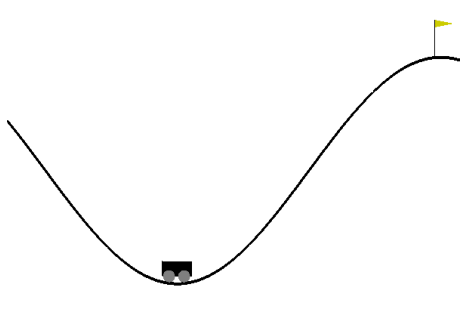

In [112]:
env_savegif(frames, "./", "treinado.gif")

In [125]:
print( RL.env.observation_space )
print( RL.env.action_space )

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


ajustando recompensa

+ [https://tims457.medium.com/solving-mountain-car-with-q-learning-b77bf71b1de2](https://tims457.medium.com/solving-mountain-car-with-q-learning-b77bf71b1de2)
+ [https://gist.github.com/tims457/244d36ea4aac872f1c3a82d3b481a99c#file-mountain-car-v0-q-learning-ipynbhttps://gist.github.com/tims457/244d36ea4aac872f1c3a82d3b481a99c#file-mountain-car-v0-q-learning-ipynb](https://gist.github.com/tims457/244d36ea4aac872f1c3a82d3b481a99c#file-mountain-car-v0-q-learning-ipynbhttps://gist.github.com/tims457/244d36ea4aac872f1c3a82d3b481a99c#file-mountain-car-v0-q-learning-ipynb)

In [547]:
from torch.distributions import Categorical

DEVICE = "cpu"

In [548]:
class Model(nn.Module):
    def __init__(self, dim_estados, dim_acoes, hparam_rede):
        super(Model, self).__init__()
        
        self.hparam_rede = dict()
        
        self.dim_estados = dim_estados
        self.dim_acoes = dim_acoes
        self.hparam_rede = hparam_rede
        
        self.constroi_modelo()
    
        
    def constroi_modelo(self):
        self.input = nn.Linear( self.dim_estados, self.hparam_rede['hidden_layers'][0] )
        self.hidden = nn.ModuleList()
        for i in range(len(self.hparam_rede['hidden_layers'])-1):
            self.hidden.append(nn.Dropout(0.1))
            self.hidden.append( nn.Linear(self.hparam_rede['hidden_layers'][i], self.hparam_rede['hidden_layers'][i+1]) )
        self.output = nn.Linear( self.hparam_rede['hidden_layers'][-1], self.dim_acoes )
    
    
    def forward(self, estado):
        x = estado
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = self.hparam_rede['func_ativacao']( self.input(x) )
        for h in self.hidden:
            x = self.hparam_rede['func_ativacao']( h(x) )
        # x = F.softmax(self.output(x), dim=0)
        x = self.output(x)
        
        return x

In [549]:
class Agent(object):
    def __init__(self, hparams_ambiente, hparams_model, hparams_reforco):
        self.dim_estados = hparams_ambiente['estados']
        self.dim_acoes = hparams_ambiente['acoes']

        self.hparams_model = dict()
        self.hparams_reforco = dict()
        self.memoria = collections.deque()

        self.hparams_model['hidden_layers'] = hparams_model['hidden_layers']
        self.hparams_model['func_ativacao'] = hparams_model['func_ativacao']
        self.modelo = Model(self.dim_estados, self.dim_acoes, self.hparams_model)
        self.hparams_model['func_opt'] = hparams_model['func_opt'](self.modelo.parameters(), lr=0.001)
        self.hparams_model['func_loss'] = hparams_model['func_loss']
     
        self.hparams_reforco['gamma'] = 0.99
        
        
    def act(self, estado, epsilon=0.0):
        x = torch.from_numpy(estado).float().unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            acoes = self.modelo(x)
        
        if random.random() > epsilon:
            return np.argmax(acoes.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.dim_acoes))

    
    def remember(self, estado, acao, reward, proximo_estado, done):
        self.memoria.append( (estado, acao, reward, proximo_estado, done) )
    
        
    def learn(self):
        estados, acoes, rewards, prx_estados, dones = list(map(list, zip(*self.memoria)))

        estados = torch.FloatTensor(estados).to(DEVICE)
        prx_estados = torch.FloatTensor(prx_estados).to(DEVICE)
        acoes = torch.LongTensor(acoes).to(DEVICE).view(-1, 1)
        rewards = torch.FloatTensor(rewards).to(DEVICE).view(-1, 1)
        dones = torch.IntTensor(dones).to(DEVICE).view(-1, 1)
        
        max_a_q_sp = self.modelo(prx_estados).detach().max(1)[0].unsqueeze(1) * (1 - dones)
        target_q_s = rewards + max_a_q_sp
        q_sa = self.modelo(estados).gather(1, acoes)
        
        loss = self.hparams_model['func_loss']( target_q_s, q_sa )
        self.hparams_model['func_opt'].zero_grad()
        loss.backward()
        self.hparams_model['func_opt'].step()
        self.memoria = collections.deque()

In [550]:
class Solver():
    def __init__(self, ambiente, hparams_model, hparams_reforco):
        self.env = ambiente
        
        self.hparams_ambiente = dict()
        self.hparams_model = hparams_model
        self.hparams_reforco = hparams_reforco
        
        self.hparams_ambiente['estados'] = self.env.observation_space.shape[0]
        self.hparams_ambiente['acoes'] = self.env.action_space.n
        
        self.agent = Agent(self.hparams_ambiente, self.hparams_model, self.hparams_reforco)
        self.scores = list()
        self.sucesso = 0
        self.epsilon = 0.333
        self.max_score = -np.inf
        
    def solve(self, episodios):
        estado = self.env.reset()
        
        for e in range(episodios + 1):
            estado = self.env.reset()
            score = 0
            done = False
            # epsilon = max( 1 -  e/episodios, 0.05)

            for _ in range(self.hparams_reforco["MAX"]):
                acao = self.agent.act(estado, self.epsilon)                # observe state -> take action
                prx_estado, reward, done, _ = self.env.step(acao)          # feedback -> new state
                
                #score += reward                                           # recompensa
                score = prx_estado[0] + 0.5
                if prx_estado[0] >= 0.5:
                    score += 1
                
                if score > self.max_score:
                    self.max_score = score
                
                self.agent.remember(estado, acao, score, prx_estado, done)
                if done:
                    if prx_estado[0] >= 0.5:
                        self.epsilon *= .9
                        self.sucesso += 1
                        print(rf"RESOLVIDO! (episodio {e}, {self.sucesso} sucessos, score {score})")
                        break
                else:
                    estado = prx_estado                                        # novo estado
            self.agent.learn()
            self.scores.append(score)

            if (e % 100 == 0) and (e > 1):
                print( "episodio : {:>6} de {:>6}  |  (score, media movel, media, mediana, epsilon) = ({:>3}, {:>3}, {:>3}, {:>3}, {:>3}) | max score : {:>3}".format(
                    e, episodios, round(score, 3), round(np.mean(self.scores[-100:]),3), round(np.mean(self.scores), 3), round(np.median(self.scores), 3), round(self.epsilon, 3), round(self.max_score, 3)) )

In [551]:
hparams_model = {
    "hidden_layers" : (5, 50, 5) , 
    "func_ativacao" : F.relu ,
    "func_opt" : optim.RMSprop , 
    "func_loss" : F.mse_loss , 
}

hparams_reforco = {    
    "MAX" : 555 ,
}

RL = Solver(gym.make("MountainCar-v0"), hparams_model, hparams_reforco)

In [552]:
RL.agent.modelo

Model(
  (input): Linear(in_features=2, out_features=5, bias=True)
  (hidden): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=5, out_features=50, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_features=5, bias=True)
  )
  (output): Linear(in_features=5, out_features=3, bias=True)
)

In [553]:
torchinfo.summary(RL.agent.modelo)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            15
├─ModuleList: 1-2                        --
│    └─Dropout: 2-1                      --
│    └─Linear: 2-2                       300
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       255
├─Linear: 1-3                            18
Total params: 588
Trainable params: 588
Non-trainable params: 0

In [554]:
RL.solve(1000)

episodio :    100 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.05, 0.032, 0.032, 0.032, 0.333) | max score : 0.638
RESOLVIDO! (episodio 139, 1 sucessos, score 2.004874289035797)
episodio :    200 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.079, 0.042, 0.037, 0.032, 0.3) | max score : 2.005
episodio :    300 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.192, -0.016, 0.019, 0.025, 0.3) | max score : 2.005
episodio :    400 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.283, -0.045, 0.003, -0.004, 0.3) | max score : 2.005
episodio :    500 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.297, -0.032, -0.004, -0.009, 0.3) | max score : 2.005
episodio :    600 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.079, -0.012, -0.005, -0.01, 0.3) | max score : 2.005
episodio :    700 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.002, -0.021, -0.007, -0.01, 0.3) | max 

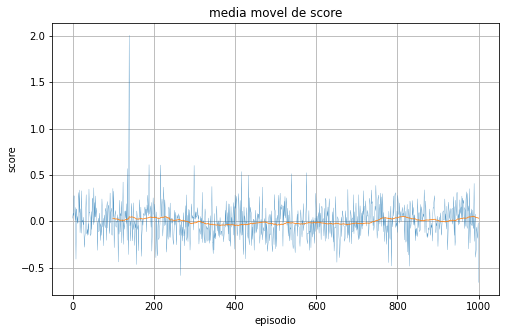

In [555]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

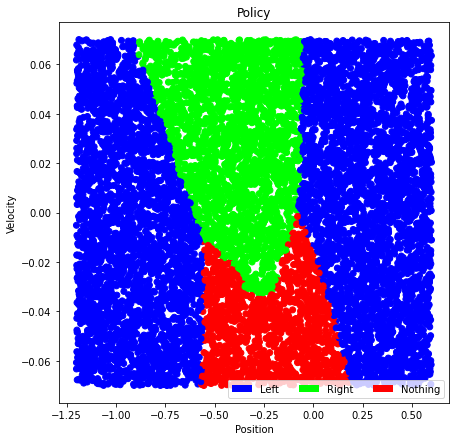

In [516]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from torch.autograd import Variable

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []

for i in range(len(X)):
    z = RL.agent.act(np.array([X[i], Y[i]])).item()
    Z.append(z)
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)

ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')

recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [517]:
env = gym.make("MountainCar-v0")
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(5000):
    action = RL.agent.act(observation)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

- - -

In [518]:
RL.solve(1000)

RESOLVIDO! (episodio 61, 2 sucessos, score 2.0182151794433594)
episodio :    100 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.144, 0.12, 0.073, 0.096, 0.27) | max score : 2.018
RESOLVIDO! (episodio 140, 3 sucessos, score 2.0031034350395203)
RESOLVIDO! (episodio 151, 4 sucessos, score 2.0065741539001465)
RESOLVIDO! (episodio 155, 5 sucessos, score 2.001562476158142)
RESOLVIDO! (episodio 176, 6 sucessos, score 2.0014885663986206)
episodio :    200 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.069, 0.159, 0.08, 0.099, 0.177) | max score : 2.018
RESOLVIDO! (episodio 214, 7 sucessos, score 2.0035122632980347)
RESOLVIDO! (episodio 275, 8 sucessos, score 2.0174933671951294)
episodio :    300 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.093, 0.159, 0.086, 0.103, 0.143) | max score : 2.018
RESOLVIDO! (episodio 323, 9 sucessos, score 2.018367648124695)
RESOLVIDO! (episodio 330, 10 sucessos, score 2.0010098814964294)
RESOLVIDO! (episodio 

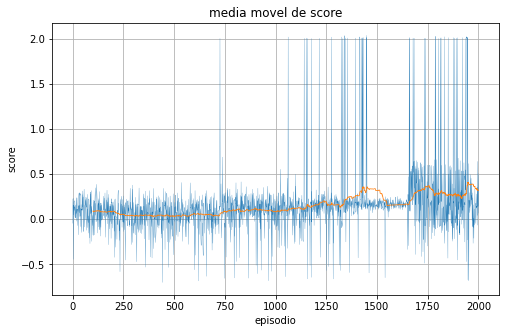

In [519]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

IndexError: list index out of range

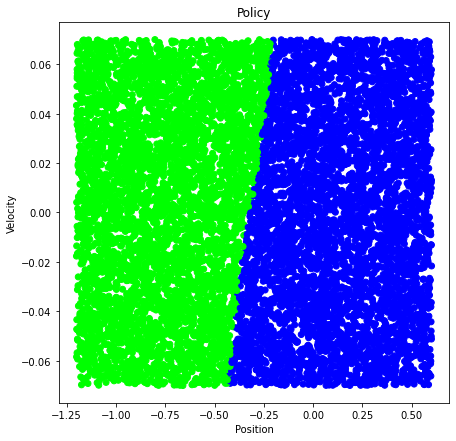

In [520]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from torch.autograd import Variable

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []

for i in range(len(X)):
    z = RL.agent.act(np.array([X[i], Y[i]])).item()
    Z.append(z)
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)

ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')

recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [522]:
env = gym.make("MountainCar-v0")
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

max_pos = -np.inf

for i in range(500):
    action = RL.agent.act(observation)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if observation[0] > max_pos:
        max_pos = observation[0]
        # print(max_pos)
    if done:
        break
env.close()

In [523]:
RL.solve(1000)

RESOLVIDO! (episodio 41, 51 sucessos, score 2.004181444644928)
episodio :    100 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.092, 0.174, 0.153, 0.136, 0.002) | max score : 2.036
episodio :    200 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.045, 0.112, 0.151, 0.135, 0.002) | max score : 2.036
RESOLVIDO! (episodio 249, 52 sucessos, score 2.003628373146057)
episodio :    300 de   1000  |  (score, media movel, media, mediana, epsilon) = (-0.033, 0.128, 0.15, 0.135, 0.001) | max score : 2.036
episodio :    400 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.565, 0.158, 0.151, 0.136, 0.001) | max score : 2.036
episodio :    500 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.327, 0.12, 0.149, 0.135, 0.001) | max score : 2.036
episodio :    600 de   1000  |  (score, media movel, media, mediana, epsilon) = (0.081, 0.16, 0.15, 0.136, 0.001) | max score : 2.036
episodio :    700 de   1000  |  (score, media movel, media

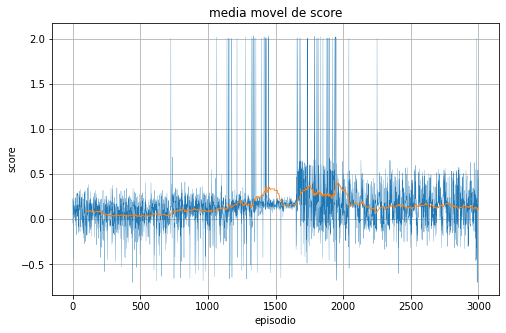

In [524]:
pd.Series(RL.scores).plot(linewidth=0.25)
pd.Series(RL.scores).rolling(100).mean().plot(linewidth=0.75, figsize=(8, 5))

plt.xlabel("episodio")
plt.ylabel("score")
plt.title("media movel de score")
plt.grid()

IndexError: list index out of range

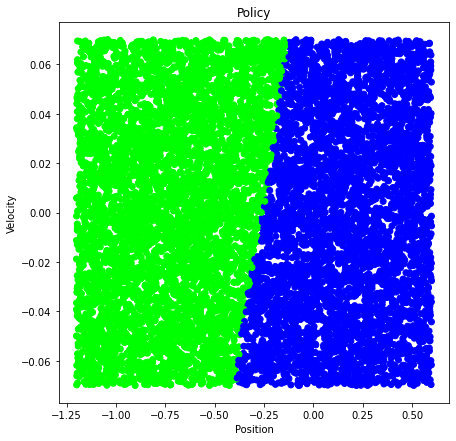

In [525]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from torch.autograd import Variable

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []

for i in range(len(X)):
    z = RL.agent.act(np.array([X[i], Y[i]])).item()
    Z.append(z)
Z = pd.Series(Z)

colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)

ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')

recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

In [526]:
env = gym.make("MountainCar-v0")
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
frames = [firstframe]

for i in range(500):
    action = RL.agent.act(observation)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    frames.append(frame)
    if done:
        break
env.close()

.